# Load and Clean the data

In [1]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from scipy.stats.stats import pearsonr 
import math

pos="TE"

plt.rcParams['figure.figsize'] = (20.0, 16.0)


gameStats = pd.read_csv('gameStats_withFeats_standard.csv')
gameStats.drop('Unnamed: 0', axis=1, inplace=True)


/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


Next, lets remove the first two years of football data (since the averages will be bad) and extract all of the players of this position.

In [2]:
POSsamples=gameStats[(gameStats['Inferred Position']==pos) & \
                   (gameStats['Week']>34) & (gameStats['NoStats']==False) & \
                   (gameStats['Player Benched']==False)].reset_index(drop=True)

Next, remove any samples with NaN features

In [3]:
#If we have 8 weeks to average over, then we also have 34 and 17 weeks to average over
#Note: it may not be a full 8,17,or 34 weeks if a lot of games are missing... not sure the best way to deal with that
POSsamples=POSsamples[POSsamples['passing_yds_8weekAvg'].apply(lambda x: not math.isnan(x))]

In [4]:
len(POSsamples)

3697

# Look at feature correlations

Let's loop over each player's, team's, and opponents stats and see which are coorelated with the final outcome

In [5]:
all_features=['Week','At Home'] + list(POSsamples.columns[74:]) #Don't bother with more than 1 year averages

def CalcCorrPoints():
    #Look at Week, Team, At Home, passing_yds:
    useful_features=[]
    for stat in all_features:
        x_stats =  POSsamples[stat] 
        y_stats =  POSsamples['FantasyPoints'] 
        if abs(pearsonr(x_stats, y_stats)[0]) > 0.2:
            print stat, "Correlation:", pearsonr(x_stats, y_stats)[0]
            useful_features.append(stat)
            
    return useful_features

useful_features = CalcCorrPoints()

PriorSeasonPoints Correlation: 0.348358837878
TwoPriorSeasonPoints Correlation: 0.261195527191
receiving_yds_8weekAvg Correlation: 0.427278118823
receiving_rec_8weekAvg Correlation: 0.417079438404
receiving_tds_8weekAvg Correlation: 0.306616268937
receiving_tar_8weekAvg Correlation: 0.419594992914
receiving_yac_yds_8weekAvg Correlation: 0.351612446726
FantasyPoints_8weekAvg Correlation: 0.419044054163
receiving_yds_17weekAvg Correlation: 0.433616885039
receiving_rec_17weekAvg Correlation: 0.415513650834
receiving_tds_17weekAvg Correlation: 0.33267298367
receiving_tar_17weekAvg Correlation: 0.415472695603
receiving_yac_yds_17weekAvg Correlation: 0.363199384055
FantasyPoints_17weekAvg Correlation: 0.427499905009
receiving_yds_34weekAvg Correlation: 0.423460387441
receiving_rec_34weekAvg Correlation: 0.402133418698
receiving_tds_34weekAvg Correlation: 0.353346696623
receiving_tar_34weekAvg Correlation: 0.399363215424
receiving_yac_yds_34weekAvg Correlation: 0.363872778669
FantasyPoints_34

In [6]:
#Remove features from two+ years ago
unwanted_features = ['TwoPriorSeasonPoints']
unwanted_types = ['team','opponent']

final_features = []
for feat in useful_features:
    
    #remove TwoPriorSeasonPoints as a feature
    if feat not in unwanted_features:
        
        #remove team and opponent stats as features
        if feat.split('_')[0] not in unwanted_types:

            #remove team and opponent stats as features
            if feat.split('_')[-1][:2] != '34':
                final_features.append(feat)        
        
final_features                       

['PriorSeasonPoints',
 'receiving_yds_8weekAvg',
 'receiving_rec_8weekAvg',
 'receiving_tds_8weekAvg',
 'receiving_tar_8weekAvg',
 'receiving_yac_yds_8weekAvg',
 'FantasyPoints_8weekAvg',
 'receiving_yds_17weekAvg',
 'receiving_rec_17weekAvg',
 'receiving_tds_17weekAvg',
 'receiving_tar_17weekAvg',
 'receiving_yac_yds_17weekAvg',
 'FantasyPoints_17weekAvg']

# Training a prediction model 

Before we begin, lets remove any zero fantasy point games from out data, since it's likely the player was injured or benched during that game.  We don't want to take that into account in our model.


In [7]:
POSsamples=POSsamples[POSsamples['FantasyPoints']!=0]


First, we need to split our sample into training, CV, and testing sets.  Let's randomly order our dataframe, using the same seed so that we get the same order every time we run this code.

In [8]:
#First, set aside one of the seasons evaluate how well we predict an entire season of games
POSsamples_2014=POSsamples[POSsamples['Season']==6]
POSsamples_2014=POSsamples_2014[POSsamples_2014['Player']!='Josh Gordon'] #delete josh gordon since he was suspended
POSsamples=POSsamples[POSsamples['Season']!=6]

In [9]:
np.random.seed(42)
POSsamples=POSsamples.reindex(np.random.permutation(POSsamples.index))
POSsamples.reset_index(inplace=True)

Now lets put half of the samples in training, a quarter in CV, and a quarter in test.

In [10]:
POS_training = POSsamples.ix[:round(len(POSsamples)/2)]
POS_cv = POSsamples.ix[round(len(POSsamples)/2): round(len(POSsamples)/2) + round(len(POSsamples)/4)]
POS_test = POSsamples.ix[round(len(POSsamples)/2) + round(len(POSsamples)/4):]

In [11]:
X_train = POS_training[final_features]
X_cv = POS_cv[final_features]
X_test = POS_test[final_features]

In [12]:
#Feature Scaling
def getFeatMinMax():
    featMinMax={}
    
    #player feats
    for feat in final_features:
        max_feat = max(POS_training[feat])
        min_feat = min(POS_training[feat])
        featMinMax[feat]= [min_feat,max_feat]
        
    return featMinMax

featMinMax=getFeatMinMax()

In [13]:
#Save the features
import cPickle
cPickle.dump(final_features, open('%s_feature_list.pickle' % pos, 'wb')) 


#Save the feature scaling info
import cPickle
cPickle.dump(featMinMax, open('%s_feature_minmax.pickle' % pos, 'wb')) 


In [14]:
#Feature Scaling
def scaleFeat(featFrame):
    
    #player feats
    for feat in final_features:
        min_feat, max_feat = featMinMax[feat]
        featFrame[feat]= (featFrame[feat] - min_feat)/(max_feat-min_feat)
        
    return featFrame

scaleFeat(X_train)
scaleFeat(X_cv)
scaleFeat(X_test)
X_train.head()

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PriorSeasonPoints,receiving_yds_8weekAvg,receiving_rec_8weekAvg,receiving_tds_8weekAvg,receiving_tar_8weekAvg,receiving_yac_yds_8weekAvg,FantasyPoints_8weekAvg,receiving_yds_17weekAvg,receiving_rec_17weekAvg,receiving_tds_17weekAvg,receiving_tar_17weekAvg,receiving_yac_yds_17weekAvg,FantasyPoints_17weekAvg
0,0.318389,0.259887,0.230769,0.095238,0.402597,0.212500,0.214342,0.361712,0.426667,0.166667,0.500000,0.270833,0.269147
1,0.809465,0.519068,0.538462,0.444444,0.787879,0.328125,0.532309,0.709728,0.795031,0.446429,0.907143,0.521978,0.582995
2,0.000415,0.173023,0.179487,0.000000,0.227273,0.258854,0.118597,0.142996,0.173913,0.000000,0.212500,0.213341,0.071800
3,0.422167,0.396716,0.430769,0.166667,0.511364,0.530469,0.312352,0.525000,0.591304,0.195312,0.593750,0.692608,0.359341
4,0.384392,0.388065,0.417308,0.333333,0.613636,0.429297,0.404058,0.452140,0.513043,0.195312,0.600000,0.384615,0.329595


In [15]:
Y_train=POS_training['FantasyPoints']
Y_cv=POS_cv['FantasyPoints']
Y_test=POS_test['FantasyPoints']

[LibSVM]RMSE: 4.53124715192
Mean Absolute Error:  1.00134711568
Mean Relative Error:  0.325360262215
Average Points: 4.80727848101
Correlation:  0.391683620017


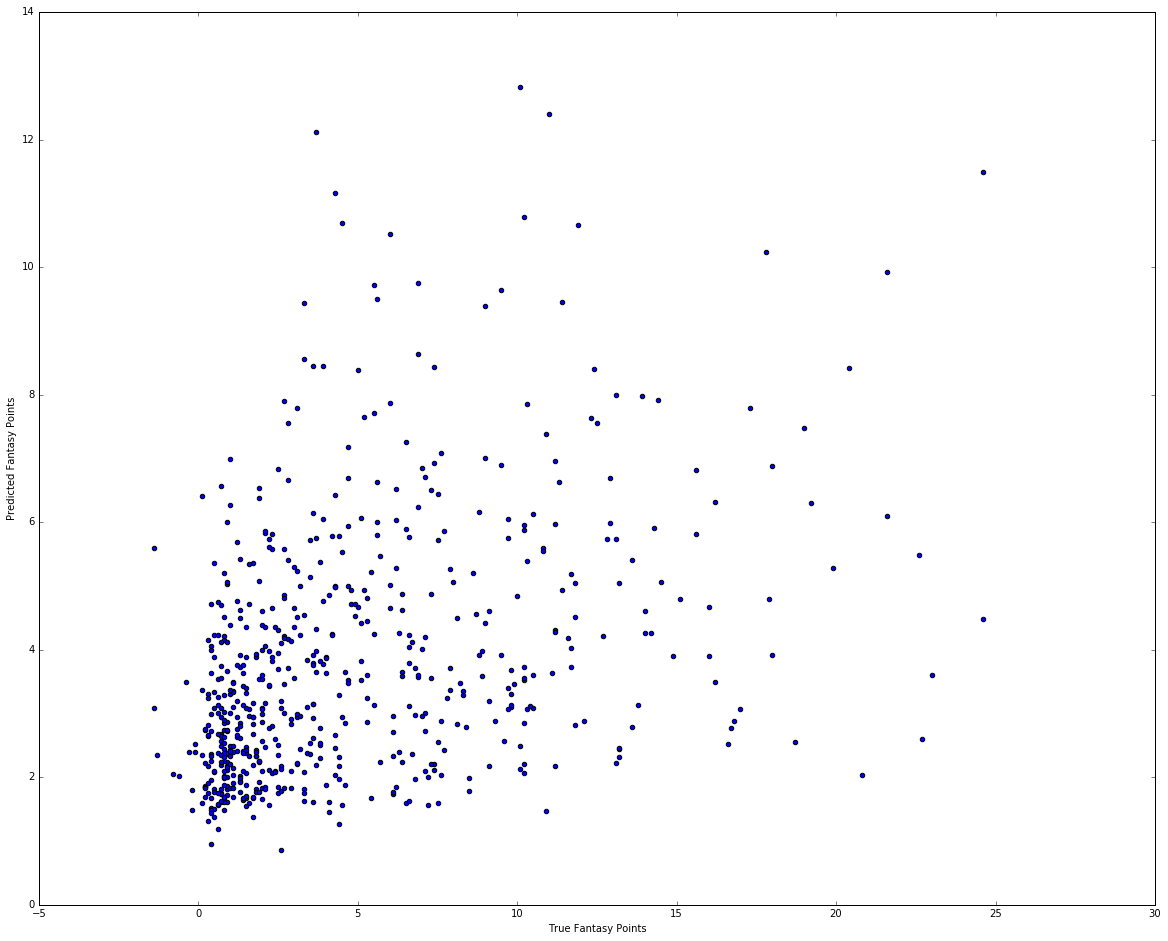

In [16]:
from sklearn.svm import SVR

from sklearn import svm
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression

#SVM works better on CV 
#lm = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=-1)
#lm.fit(X_train,Y_train)

lm=SVR(kernel='rbf', degree=1, gamma='auto', \
       coef0=100, tol=0.1, C=100, epsilon=1,\
       shrinking=True, cache_size=200, verbose=True, max_iter=-1)

lm.fit(X_train,Y_train)


#Check performance on CV data
plt.scatter(Y_cv, lm.predict(X_cv))
plt.xlabel("True Fantasy Points")
plt.ylabel("Predicted Fantasy Points")


#Calculate mean squared error
mse = np.mean((Y_cv - lm.predict(X_cv)) **2)
print 'RMSE:', np.sqrt(mse)
print 'Mean Absolute Error: ', np.mean((Y_cv - lm.predict(X_cv)))
print 'Mean Relative Error: ', np.mean((Y_cv - lm.predict(X_cv))/(lm.predict(X_cv)))
print 'Average Points:', np.mean(Y_cv)
print 'Correlation: ', pearsonr(Y_cv,lm.predict(X_cv))[0]

# Performance in 2014, allowing predictor to update as season goes on

In [17]:
features_2014 = POSsamples_2014[final_features]
scaleFeat(features_2014)
predictions_2014 = lm.predict(features_2014)
results_2014=POSsamples_2014['FantasyPoints']

/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RMSE: 4.53236518191
Mean Absolute Error:  0.915178522115
Mean Relative Error:  0.304500580031
Average Points: 4.77247340426
Correlation:  0.409650511413


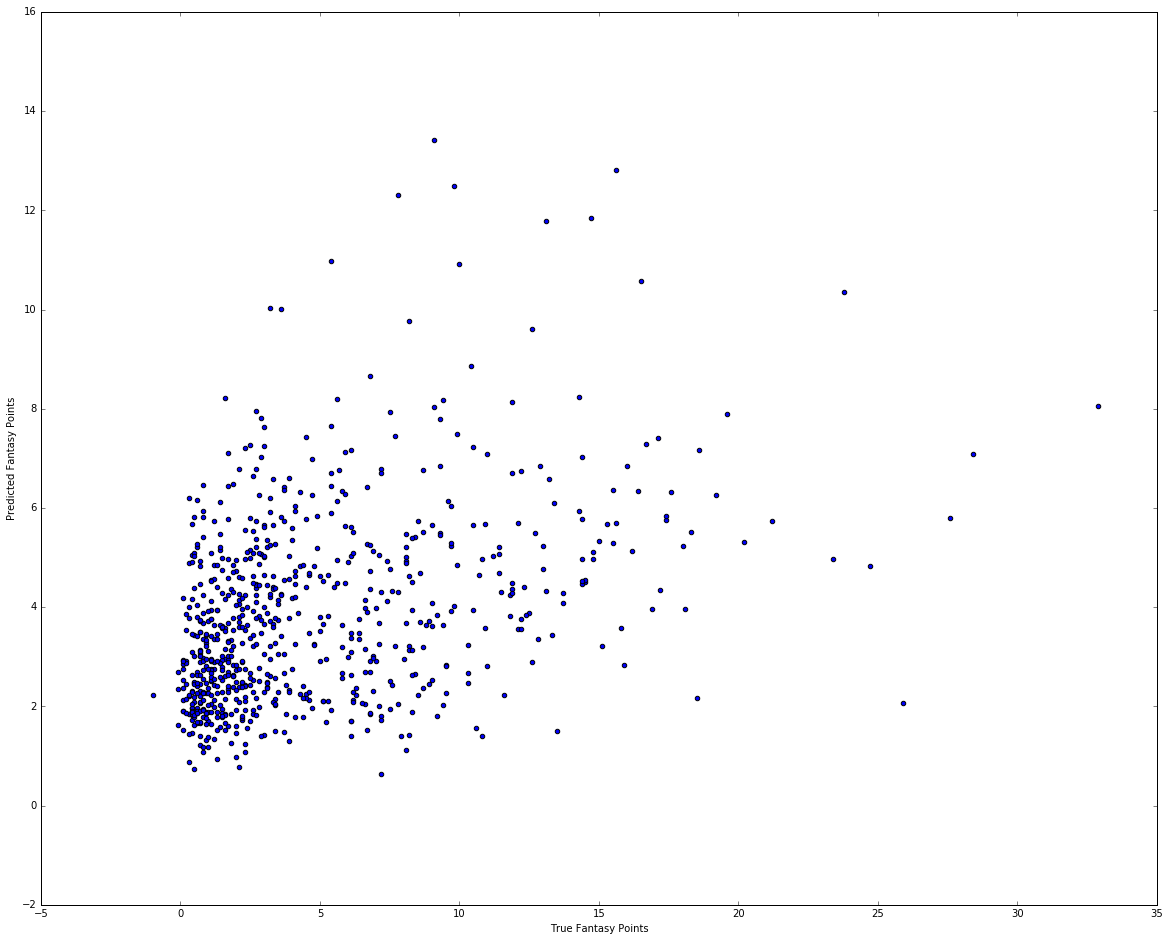

In [18]:
#Check performance on each prediction
plt.scatter(results_2014,predictions_2014)
plt.xlabel("True Fantasy Points")
plt.ylabel("Predicted Fantasy Points")

mse = np.mean((results_2014 - predictions_2014) **2)
print 'RMSE:', np.sqrt(mse)
print 'Mean Absolute Error: ', np.mean((results_2014 - predictions_2014))
print 'Mean Relative Error: ', np.mean((results_2014 - predictions_2014)/(predictions_2014))
print 'Average Points:', np.mean(results_2014)
print 'Correlation: ', pearsonr(results_2014,predictions_2014)[0]

In [19]:
POSsamples_2014['PredictedFantasyPoints']=predictions_2014

season_totals=POSsamples_2014.groupby('PlayerID').sum()['FantasyPoints'].tolist()
predicted_season_totals=POSsamples_2014.groupby('PlayerID').sum()['PredictedFantasyPoints'].tolist()


RMSE: 15.9303774987
Mean Absolute Error:  7.73274436663
Mean Relative Error:  0.205540009132
Average Points: 40.3247191011
Correlation:  0.962366740283


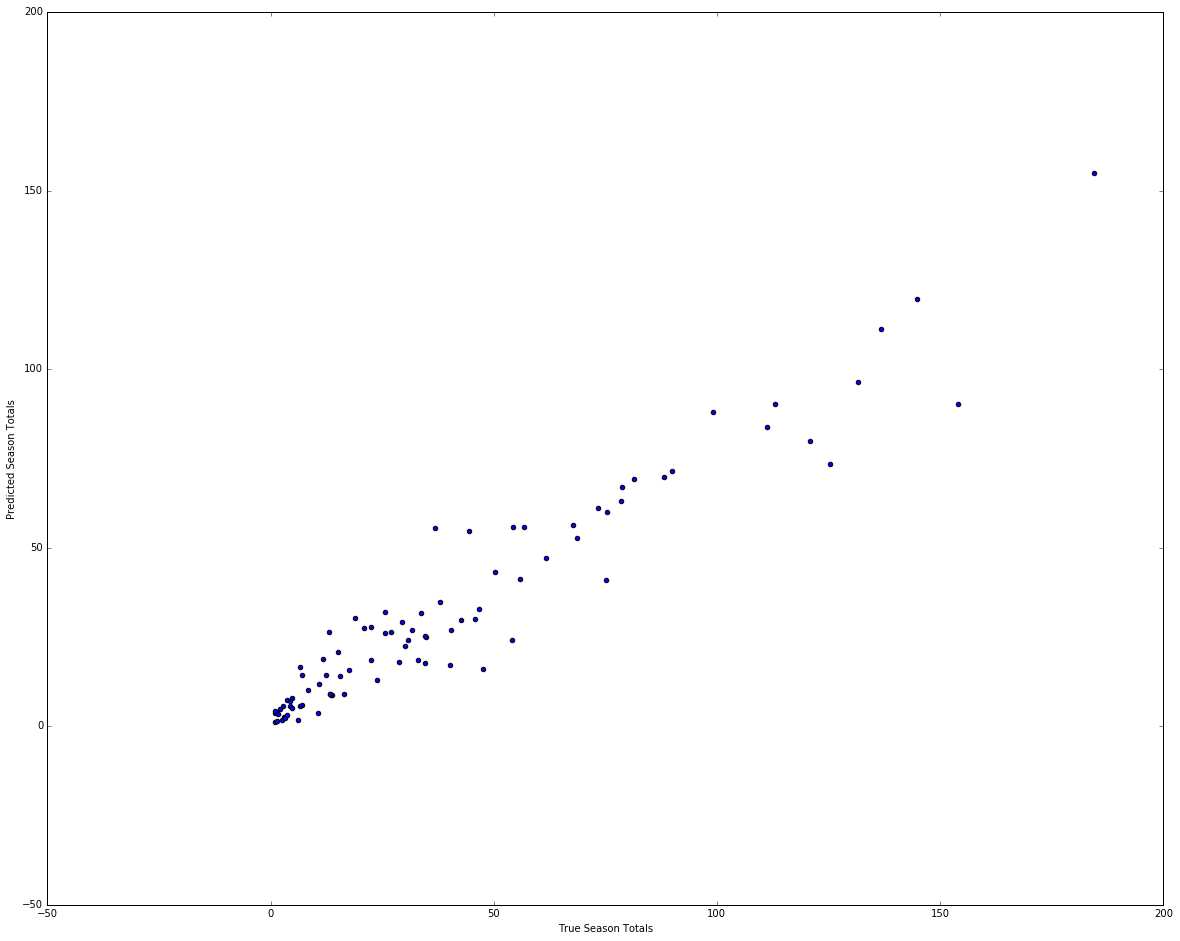

In [20]:
#Check performance on each prediction with predictions updating throughout the season
plt.scatter(season_totals,predicted_season_totals)
plt.xlabel("True Season Totals")
plt.ylabel("Predicted Season Totals")

season_totals=np.array(season_totals)
predicted_season_totals=np.array(predicted_season_totals)
mse = np.mean((season_totals - predicted_season_totals) **2)
print 'RMSE:', np.sqrt(mse)
print 'Mean Absolute Error: ', np.mean((season_totals - predicted_season_totals))
print 'Mean Relative Error: ', np.mean((season_totals - predicted_season_totals)/(predicted_season_totals))
print 'Average Points:', np.mean(season_totals)
print 'Correlation: ', pearsonr(season_totals,predicted_season_totals)[0]

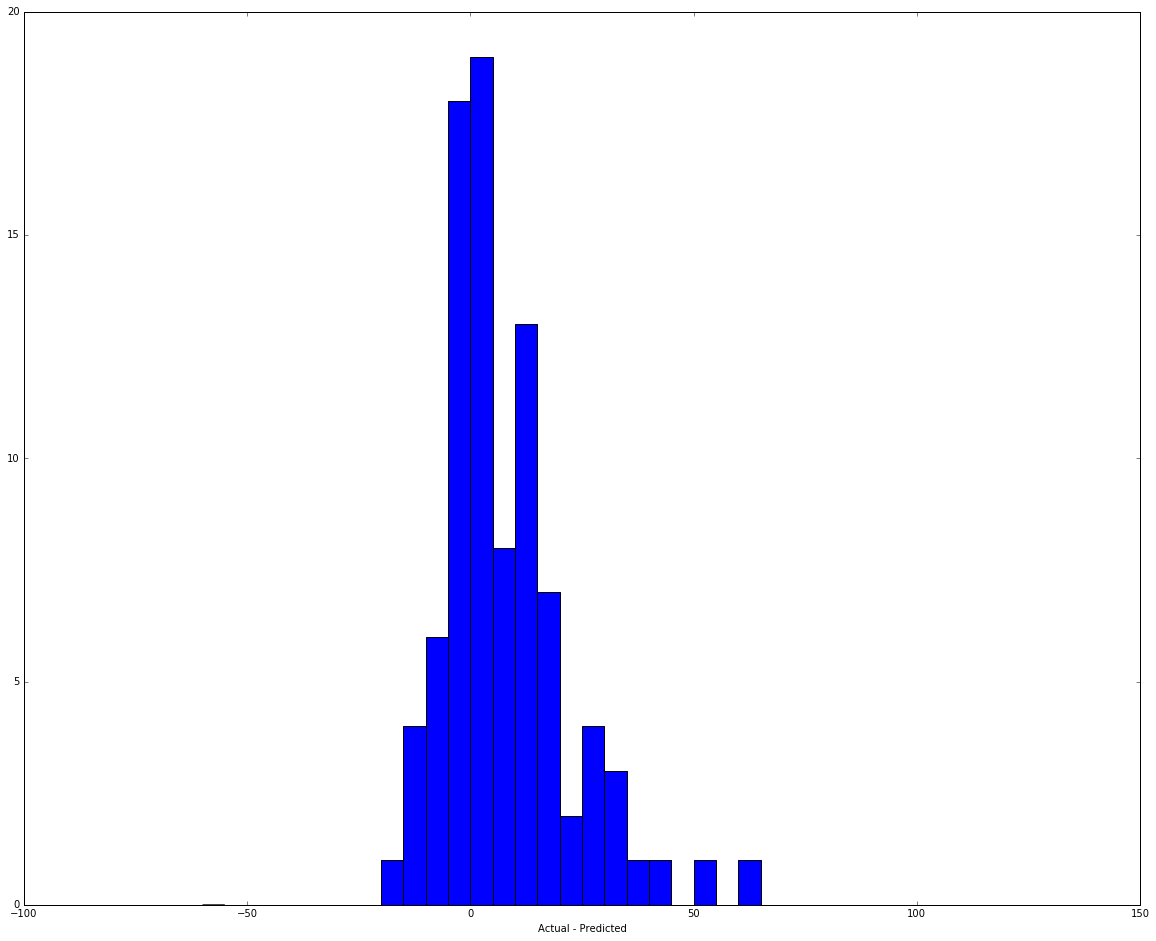

In [21]:
#Plot histogram of prediction errors
errors_2014 = season_totals-predicted_season_totals

tarHist=np.hstack(errors_2014)
plt.hist(tarHist, bins=range(-60,150,5))
plt.xlabel('Actual - Predicted')
plt.show()

# Save the Classifier 


In [22]:
#Save the classifier
from sklearn.externals import joblib
joblib.dump(lm, '%s_predictor.pickle' % pos) 


['TE_predictor.pickle']

# Evaluate performance on random test set

RMSE: 4.68445316568
Mean Absolute Error:  0.899285087713
Mean Relative Error:  0.280617217271
Average Points: 5.00774091627
Correlation:  0.372640113908


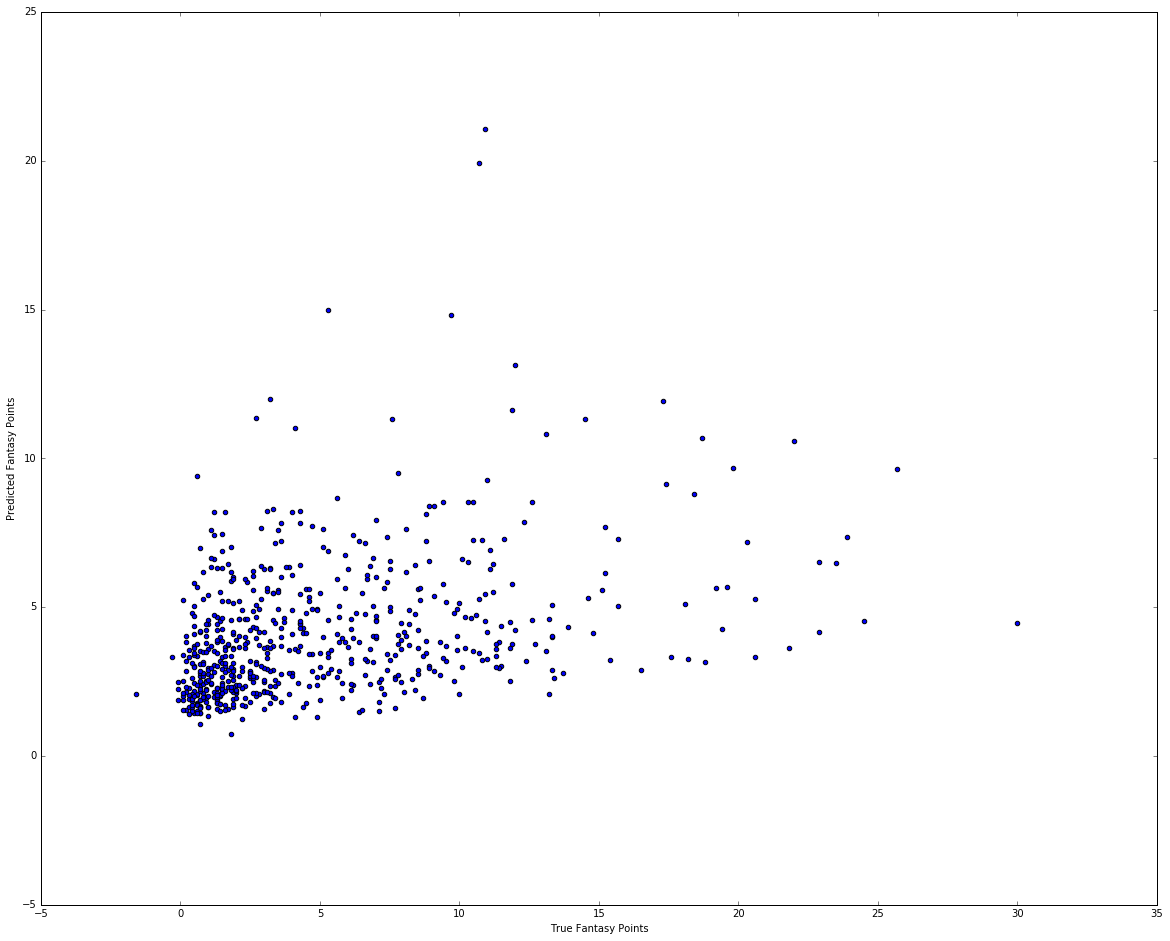

In [23]:
#Check performance on CV data
plt.scatter(Y_test, lm.predict(X_test))
plt.xlabel("True Fantasy Points")
plt.ylabel("Predicted Fantasy Points")


#Calculate mean squared error
mse = np.mean((Y_test - lm.predict(X_test)) **2)
print 'RMSE:', np.sqrt(mse)
print 'Mean Absolute Error: ', np.mean((Y_test - lm.predict(X_test)))
print 'Mean Relative Error: ', np.mean((Y_test - lm.predict(X_test))/(lm.predict(X_test)))
print 'Average Points:', np.mean(Y_test)
print 'Correlation: ', pearsonr(Y_test,lm.predict(X_test))[0]

# Performance in 2014 test season

In [24]:
#load stat database
stat_db = pd.read_csv('gameStats_withFeats_standard.csv')
stat_db.drop('Unnamed: 0', axis=1, inplace=True)


aggregate_stats=['defense_int_tds','defense_misc_tds','defense_sk','defense_frec_tds',\
               'defense_frec_tds','defense_puntblk','defense_fgblk',\
               'defense_xpblk','defense_int','defense_frec','defense_safe',\
               'defense_ffum','defense_pass_def','defense_int_yds',\
               'defense_tkl_loss','defense_tkl_loss_yds']

In [25]:
#SHOULD MAKE A DATAFRAME WITH AN ENTRY FOR EACH PLAYER, AND QUERY MY STATS DATABASE TO FILL IN EACH FEATURE
df_2014 = pd.DataFrame()
df_2014['PlayerID']=POSsamples_2014['PlayerID'].unique().tolist()
df_2014.head(n=5)

,PlayerID
0,00-0022127
1,00-0024221
2,00-0027753
3,00-0030089
4,00-0030443


In [26]:
'''All of this information should be collected from ESPN or something for 2016'''

#Not sure how I'll get playerID from ESPN

#Fill in season information - 2014 is season 6
df_2014['Season']=6 

#Fill in the week info following week 1 is first week in 2009
df_2014['Week']=df_2014.apply(lambda row: (row['Season']-1)*17  + 1 ,axis=1)

#Fill in player names
def FillPlayers(row):
    player_id=row['PlayerID']
    player = gameStats[gameStats['PlayerID'] == player_id]['Player'].tolist()[0]
    return player

df_2014['Player']=df_2014.apply(FillPlayers,axis=1)

#Fill in player teams
def FillTeams(row):
    player_id=row['PlayerID']
    team = POSsamples_2014[POSsamples_2014['PlayerID'] == player_id]['Team'].tolist()[0]
    return team

df_2014['Team']=df_2014.apply(FillTeams,axis=1)

df_2014.head()

,PlayerID,Season,Week,Player,Team
0,00-0022127,6,86,Jason Witten,DAL
1,00-0024221,6,86,Vernon Davis,SF
2,00-0027753,6,86,Andrew Quarless,GB
3,00-0030089,6,86,Luke Willson,SEA
4,00-0030443,6,86,Levine Toilolo,ATL


In [27]:
'''All of this information needs to be collected from stat database'''

#Fill in previous season's fantasy points
def FindSeasonScore(row,seasons_prior):
    player=row['Player']
    player_id=row['PlayerID']
    season = row['Season']-seasons_prior
    tot_points = gameStats[(gameStats['Player']==player) & (gameStats['PlayerID']==player_id) & \
              (gameStats['Season']==season)]['FantasyPoints'].sum()
        
    return tot_points

df_2014['PriorSeasonPoints']=df_2014.apply(FindSeasonScore,args=[1] ,axis=1)
df_2014['TwoPriorSeasonPoints']=df_2014.apply(FindSeasonScore,args=[2] ,axis=1)

In [28]:
#Fill in the player's average fantasy stats
def FindPlayerAverage(row,num_weeks,opp=None):
    #Finds average stats of a player over the last num_weeks
    #Can specify and opponent to determine average against a specific opponent
    #Ignored weeks where the player had zero stats (assuming they didn't play)
    player=row['Player']
    player_id=row['PlayerID']
    current_week=row['Week']
    
    start_week = current_week - num_weeks

    #Only use games against the opponent
    if opp:
        means = gameStats[(gameStats['Player']==player) & \
                  (gameStats['PlayerID']==player_id) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['NoStats']==False) & \
                  (gameStats['Opponent']==opp) & \
                  (gameStats['Week']<current_week)].ix[:,'passing_yds':'FantasyPoints'].mean()

    else:
        means = gameStats[(gameStats['Player']==player) & \
                  (gameStats['PlayerID']==player_id) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['NoStats']==False) & \
                  (gameStats['Week']<current_week)].ix[:,'passing_yds':'FantasyPoints'].mean()
        
    return means


num_weeks=8
avgStats = df_2014.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2014 = pd.concat([df_2014,avgStats],axis=1)

num_weeks=17
avgStats = df_2014.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2014 = pd.concat([df_2014,avgStats],axis=1)

num_weeks=34
avgStats = df_2014.apply(FindPlayerAverage,args=[num_weeks],axis=1)
avgStats.columns = [('%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2014 = pd.concat([df_2014,avgStats],axis=1)


In [29]:
def FindTeamAverage(row,num_weeks,opp=None):
    team=row['Team']
    current_week=row['Week']
    
    start_week = current_week - num_weeks

    #Only use games against the opponent
    if opp:
        means = gameStats[(gameStats['Team']==team) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['Opponent']==opp) & \
                  (gameStats['Week']<current_week)].groupby(['Week']).sum().ix[:,'passing_yds':'FantasyPoints'].mean()

    else:
        means = gameStats[(gameStats['Team']==team) & \
                  (gameStats['Week']>=start_week) & \
                  (gameStats['Week']<current_week)].groupby(['Week']).sum().ix[:,'passing_yds':'FantasyPoints'].mean()
    
    for key in aggregate_stats:
        means[key]=means[key]/2 #get rid of double counting
    
    return means

#8 week average (0.5 season)
num_weeks=8
avgStats = df_2014.apply(FindTeamAverage,args=[num_weeks],axis=1)
avgStats.columns = [('team_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2014 = pd.concat([df_2014,avgStats],axis=1)

#17 week average (1 season)
num_weeks=17
avgStats = df_2014.apply(FindTeamAverage,args=[num_weeks],axis=1)
avgStats.columns = [('team_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2014 = pd.concat([df_2014,avgStats],axis=1)

#34 week average (2 season)
num_weeks=34
avgStats = df_2014.apply(FindTeamAverage,args=[num_weeks],axis=1)
avgStats.columns = [('team_%s_%dweekAvg' % (column,num_weeks)) for column in avgStats.columns]
df_2014 = pd.concat([df_2014,avgStats],axis=1)

In [30]:
#Not filling in opponent informaton for season predictions since it isn't a useful feature
#If I did inlucde it, I'd have to predict each week one by one based on who the team was playing
#Then add all predictions, instead of multiplying the first week prediction by 16

In [31]:
#NOTE: HAVE TO SAVE A COPY OF THE ORIGINAL DATA SET WE TRAINED ON SO THAT WE CAN GET THE SAME SCALING EVERY TIME
def FillPredictions(row):
    features = row[final_features]
    if True in [math.isnan(entry) for entry in features]:
        return None
    else:
        scaleFeat(features)   
        prediction = lm.predict(features.reshape(1,-1))[0]
        return prediction
    
df_2014['PredictedWeekOnePoints']=df_2014.apply(FillPredictions,axis=1)
df_2014['PredictedSeasonPoints']=df_2014['PredictedWeekOnePoints']*16

In [32]:
#Fill in actual outcomes (not needed in 2016 implementation)
season_points=[]
for player_id in df_2014['PlayerID']:
    season_points.append(POSsamples_2014[POSsamples_2014['PlayerID']==player_id]['FantasyPoints'].sum())
    
df_2014['ActualSeasonPoints']=season_points

RMSE: 31.540573133
Mean Absolute Error:  11.2820879663
Mean Relative Error:  2.44547470237
Average Points: 57.8789133631
Correlation:  0.73456433372


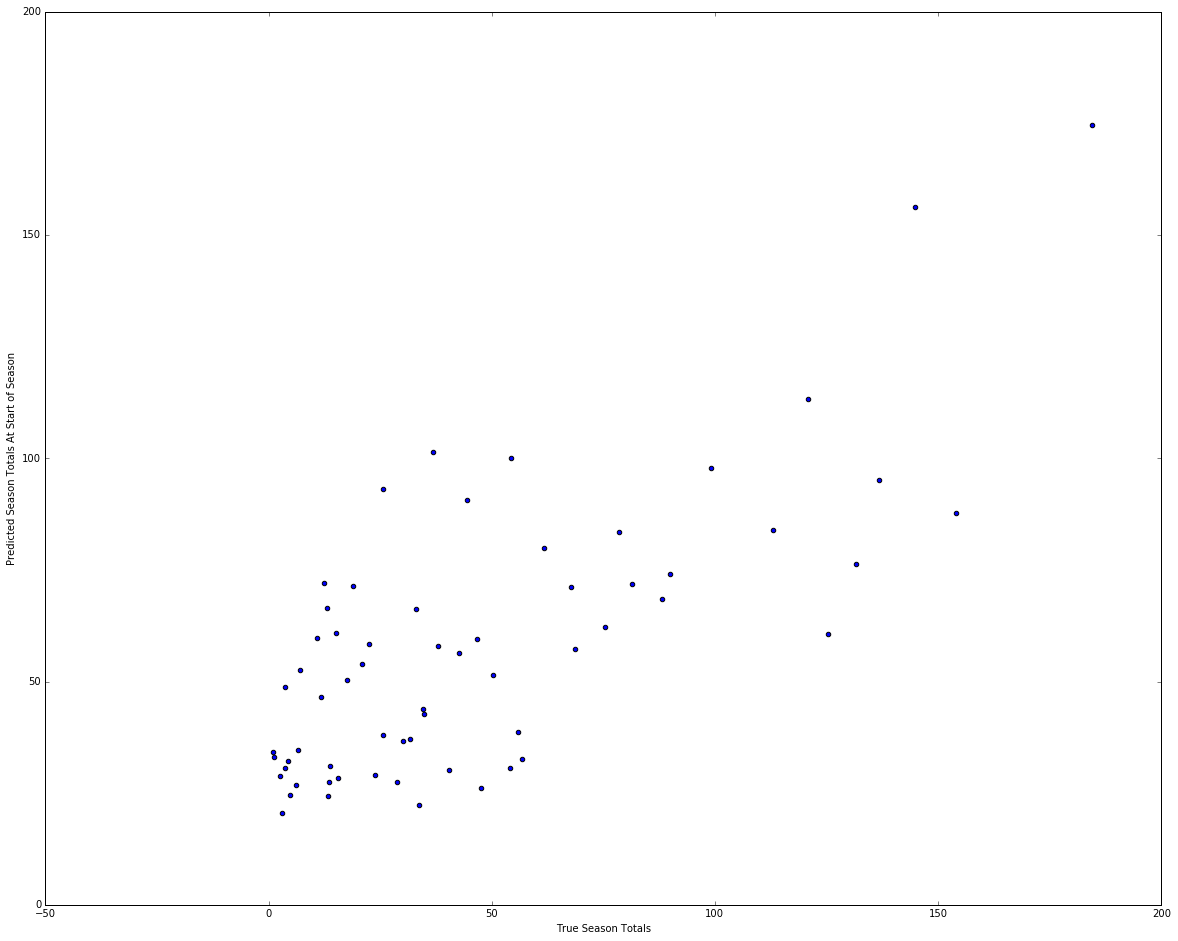

In [33]:
has_pred = df_2014['PredictedSeasonPoints'].apply(lambda x: not math.isnan(x))
x=df_2014[has_pred]['ActualSeasonPoints'].tolist()
y=df_2014[has_pred]['PredictedSeasonPoints'].tolist()
x=np.array(x)
y=np.array(y)

#Check performance on each prediction based on stats at start of the season
plt.scatter(x,y)
plt.xlabel("True Season Totals")
plt.ylabel("Predicted Season Totals At Start of Season")

mse = np.mean((x - y) **2)
print 'RMSE:', np.sqrt(mse)
print 'Mean Absolute Error: ', np.mean((y - x))
print 'Mean Relative Error: ', np.mean((y - x)/(x))
print 'Average Points:', np.mean(y)
print 'Correlation: ', pearsonr(y,x)[0]

In [34]:
#Compare to http://www.fftoday.com/stats/playerstats.php?Season=2014&GameWeek=&PosID=30&LeagueID=107644
#Make easy to use lists of the predictions
season_ranking = df_2014.sort(['PredictedSeasonPoints'],ascending=[False]).reset_index()

predicted_points = season_ranking['PredictedSeasonPoints'].tolist()
predicted_points = [points for points in predicted_points if not math.isnan(points)]
ranks = range(len(predicted_points))
players = season_ranking['Player'].tolist()
players = players[:len(predicted_points)]


/Users/richardknoche/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


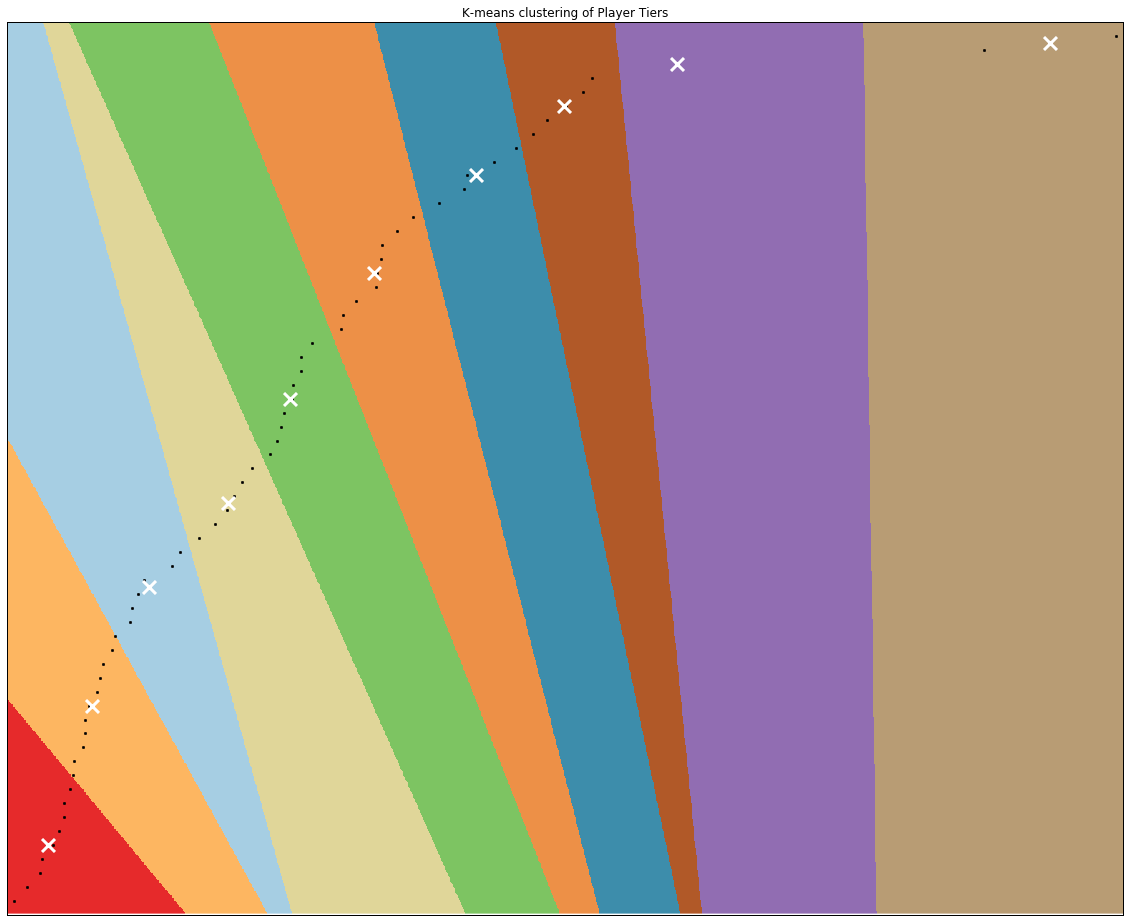

In [35]:
#CLUSTER THE RESULTS TO PRODUCE TIERS

from sklearn.cluster import KMeans
reduced_data= np.array(zip(predicted_points,ranks))
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.1     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering of Player Tiers')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.gca().invert_yaxis()
plt.show()


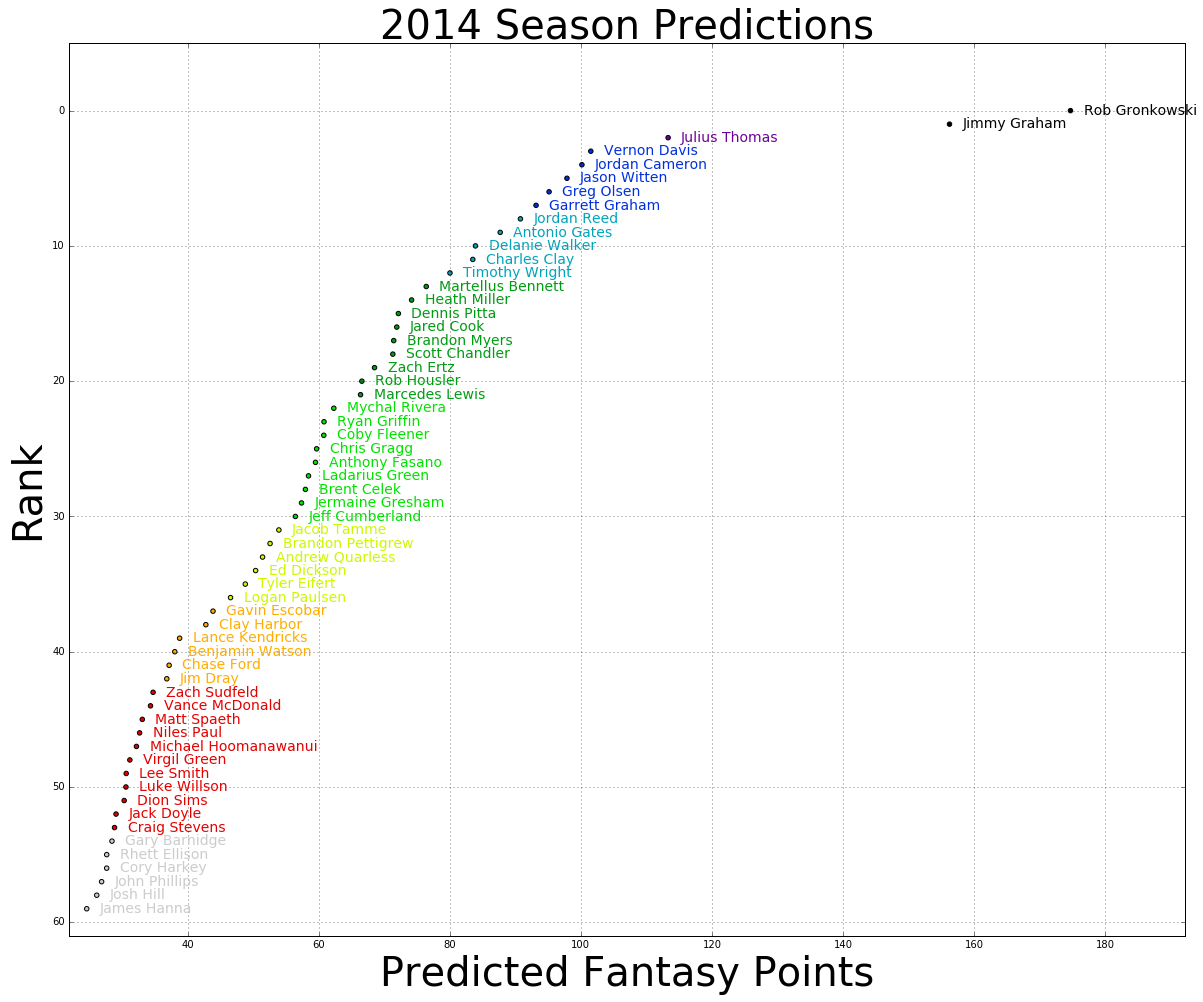

In [36]:
num_players=60

current_color=kmeans.labels_[0]
new_color=max(kmeans.labels_)+1
final_colors=[]
for color in kmeans.labels_:
    if color==current_color:
        final_colors.append(new_color)
    else:
        current_color = color
        new_color=new_color+1
        final_colors.append(new_color)
        
norm = matplotlib.colors.Normalize(vmin=min(final_colors), vmax=max(final_colors), clip=True)
colors=matplotlib.cm.ScalarMappable(norm=norm, cmap=matplotlib.cm.spectral).to_rgba(final_colors)

plt.scatter(predicted_points[:num_players],ranks[:num_players],c=colors[:num_players])
plt.xlabel("Predicted Fantasy Points",size=40)
plt.ylabel("Rank",size=40)
plt.title("2014 Season Predictions",size=40)
plt.ylim([-5,61])
plt.xlim([predicted_points[num_players]*0.9,predicted_points[0]*1.1])

for idx, player in enumerate(players[:num_players]):
    plt.annotate(player, (predicted_points[idx]+2,ranks[idx]), va='center', size=14, color=colors[idx])
    
plt.gca().invert_yaxis()
plt.grid()
plt.show()